# MNIST Handwritten Digits Recognition with MLP and Keras

This notebook presents a simple guideline on how to implement a handwritten digit recognition with a simple neural networks called Multilayer Perceptron. In this guideline, I will use the ```tensorflow.keras``` high-level API to build the classifier.

## Requirements

Tensorflow 2.x

Run the following cell to import requirements

In [1]:
from tensorflow import keras

import matplotlib.pyplot as plt

## Load and Visualize MNIST data

The MNIST data is incorporated in the ```keras``` library. It contains $70.000$ grayscale images of handwritten digits separated into a training set of $60.000$ examples and a test set of $10.000$ examples. We can simply load the data by running the following cell.

1. ```(x_train, y_train)``` : is the training set.
2. ```(x_test, y_test)``` : is the test set.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

Each training example is a $28\times28$ pixels image associated with a label corresponding to its value. Run the cell below to randomly visualize 10 examples of handwritten digits with their corresponding labels. Run this cell multiple times to see another examples.

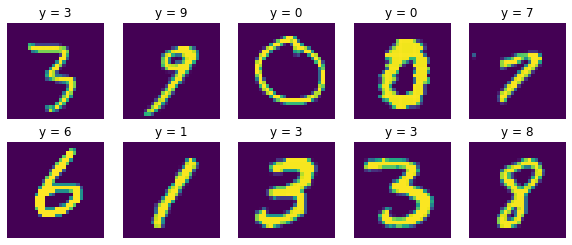

In [3]:
import numpy as np

# select 10 random images from the first 100 examples
rand_examples = np.random.randint(100, size=10)

# defining the grid
cols = 5
rows = 2

# size of images in the grid
fig = plt.figure(figsize = (10,4))

axis = []

for i, expl in enumerate(rand_examples) :
    # get the img and its corresponding label
    img = x_train[expl,:,:]
    label = y_train[expl]
    
    # add subplot to the grid
    axis.append(fig.add_subplot(rows,cols,i+1))
    
    # display current image in the grid
    axis[i].imshow(img)
    axis[i].set_title("y = {}".format(label))
    plt.axis("off")

In [4]:
print(x_train.shape[0], 'training examples of shape ',x_train.shape[1:])
print(y_train.shape[0], 'labels for training examples')
print(x_test.shape[0], 'test examples of shape ',x_test.shape[1:])
print(y_test.shape[0], 'labels for test examples')
x_train.dtype

60000 training examples of shape  (28, 28)
60000 labels for training examples
10000 test examples of shape  (28, 28)
10000 labels for test examples


dtype('uint8')

## Preprocess and Normalize data

The pixel intensities of MNIST data are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0). Since we will gradient descent to train our classifier, we need these values to be floats instead of intergers. Moreover, in order to efficiently train the model using gradient descent, we will scale the pixel intensities down to the 0-1 range by dividing them by 255.0.

In [5]:
x_train, x_test = x_train / 255.0, x_test / 255.0

## Define the model

The model defined here is a 4 layers MLP :

1. Inuput layer. The input layer is a flatten vector of the input image. Pixel values are enrolled into a long vector of shape $(784,)$. This is the ```Flatten``` layer
2. Hidden 1 : 300 units
3. Hidden 2 : 100 units
4. Output layer : 10 units. It contains as many output as there are output classes (10 output classes from 0 to 9). Each unit in the output layer outputs the probability that the input image belongs to the corresponding class.

The figure below present the summary of our model

<img src="img/mnist-model.png">

In [6]:
model = keras.models.Sequential([
    # input layer : enroll the input image into a long vector of shape (784,)
    keras.layers.Flatten(input_shape=(28,28)),
    
    # hidden 1
    keras.layers.Dense(300, activation='relu'),
    
    # hidden 2
    keras.layers.Dense(100, activation='relu'),
    
    # output layer
    keras.layers.Dense(10, activation='softmax')
])

## Compile the model

1. loss : ```sparse_categorical_crossentropy``` is used for integer labels $y\in\{0,...,9\}$. If labels were one hot representations of these values, we would have used ```categorical_crossentropy```.
2. optimizer : ```SGD```.
3. metrics : ```['accuracy']```

In [7]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(lr=0.00001),
    metrics=['accuracy']
)

## Fit the model

One of the most important hyperparameter to tune when training machine learning model is the learning rate ```lr```. The performance of the model largely depends on the value of the learning rate.

### How to choose the appropriate learning rate for a model ?

1. Initialize the learning rate with a very low value, say $10^{-5}$
2. Train the model for a few hundred iterations
3. After each iteration, increase the learning rate by by multiplying it by a constant factor, say $\exp(\log(10^6 )/500)$
4. After training, plot the loss as a function of the learning rate.
5. The optimal learning will be a bit lower than the point that minimize the loss

- Initialize the learning rate to be $10^{-5}$ with ```SGD(lr=0.00001)```
- By training the model with ```batch_size=2```, the training process will iterate 30k times to process the entire training set.
- After each iteration, multiply the learning by a ```factor=1.0004```. You can change this value to experiment it yourself. Class ```LearningRateSchedule``` is called while training and after each batch iteration, function ```on_batch_end()``` increase the learning rate.

In [8]:
K = keras.backend

class LearningRateSchedule(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.lrates = []
        self.losses = []
    
    def on_batch_end(self, epoch, logs):
        # keep track of the current learning rate and loss
        self.lrates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs.get('loss'))
        
        # increase the learning rate, by multiplying it by the factor
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

factor=1.0004
lr_scheduler = LearningRateSchedule(factor=factor)

Now, let's fit the model with one epochs to find the appropriate learning rate

In [9]:
model.fit(
    x_train,
    y_train,
    epochs=1,
    batch_size=2,
    validation_data=(x_test, y_test),
    callbacks=[lr_scheduler]
)

30000/30000 [==============================] - 85s 3ms/step - loss: 1.4991 - accuracy: 0.5150 - val_loss: 2.5854 - val_accuracy: 0.1028


Now let's plot the lost as a function of the learning rate.

Text(0, 0.5, 'Loss')

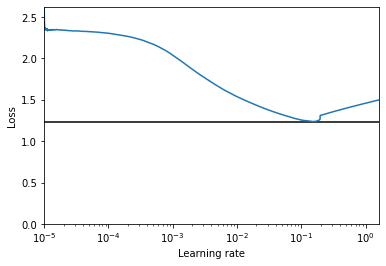

In [10]:
plt.plot(lr_scheduler.lrates, lr_scheduler.losses)
plt.gca().set_xscale('log')
plt.hlines(min(lr_scheduler.losses), min(lr_scheduler.lrates), max(lr_scheduler.lrates))
plt.axis([min(lr_scheduler.lrates), max(lr_scheduler.lrates), 0, lr_scheduler.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss goes down and starts shooting back up violently around 1e-1. Let's sort the losses according to the learning rate to know exactly which value to use.

In [11]:
loss_lr = zip(lr_scheduler.losses, lr_scheduler.lrates)
loss_lr = sorted(loss_lr)
best_lr = loss_lr[0][1]
print("min_loss = ", loss_lr[0][0])
print("corresponding lr = ", loss_lr[0][1])

min_loss =  1.2369022369384766
corresponding lr =  0.153857


$lr=0.1400017$ is then the learning rate that minimizes the loss.

In [12]:
new_lr = best_lr - 0.0001

In [13]:
keras.backend.clear_session

<function tensorflow.python.keras.backend.clear_session()>

In [14]:
model = keras.models.Sequential([
    # input layer : enroll the input image into a long vector of shape (784,)
    keras.layers.Flatten(input_shape=(28,28)),
    
    # hidden 1
    keras.layers.Dense(300, activation='relu'),
    
    # hidden 2
    keras.layers.Dense(100, activation='relu'),
    
    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [15]:
# recompile the model
print('learning rate lr = ', new_lr)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(lr=new_lr),
    metrics=['accuracy']
)

learning rate lr =  0.15375699272155763


In [16]:
class EarlyStopping(keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs):
        if logs.get('accuracy')>0.98:
            print('\nReaching 98% of accurary, then stopping training')
            self.model.stop_training = True

# saving checkpoint of the model
checkpoint = keras.callbacks.ModelCheckpoint('mnist_model.h5', save_best_only=True)

# stop training if it reaches 98% of accuracy
early_stopping = EarlyStopping()

In [17]:
model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2320 - accuracy: 0.9294 - val_loss: 0.1101 - val_accuracy: 0.9647
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0931 - accuracy: 0.9706 - val_loss: 0.0849 - val_accuracy: 0.9726
Epoch 3/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9802
Reaching 98% of accurary, then stopping training
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0623 - accuracy: 0.9802 - val_loss: 0.0763 - val_accuracy: 0.9757


Evaluate the model

In [18]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0763 - accuracy: 0.9757


[0.07628162205219269, 0.9757000207901001]

# Make predictions on a few test images

In [19]:
digits = x_test[:3]
model.predict(digits)

array([[2.2579873e-07, 3.2616140e-07, 8.2651983e-05, 8.6800910e-06,
        2.6704756e-09, 2.0100929e-07, 1.5946108e-09, 9.9990606e-01,
        2.9931053e-07, 1.5976882e-06],
       [3.4873278e-08, 1.3577915e-04, 9.9978071e-01, 7.8310695e-05,
        7.5654133e-10, 3.1097542e-07, 4.1567159e-06, 2.9810781e-08,
        6.7806718e-07, 7.4421788e-12],
       [7.1870801e-07, 9.9667287e-01, 4.1524289e-04, 1.0310719e-04,
        1.0528374e-03, 9.1326830e-05, 4.3149595e-04, 4.9251696e-04,
        7.2732219e-04, 1.2522334e-05]], dtype=float32)

# Author

Carmel WENGA | Applied Machine Learning Research Engineer